In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import random
from bs4 import BeautifulSoup
import scipy.optimize as sco
import re

抓股票代號

In [2]:
#抓美國市值前一百的股票代號
US100_stocks = []
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36",
    "scheme" : 'https',
    "path" : '/tw/image/Goodinfo.ico', 
    "Referer" : 'https://goodinfo.tw/tw/StockDetail.asp?STOCK_ID=0051',
    "Cookie" : 'CLIENT%5FID=20230920214311062%5F140%2E117%2E80%2E123; IS_TOUCH_DEVICE=F; SCREEN_SIZE=WIDTH=1920&HEIGHT=1080; TW_STOCK_BROWSE_LIST=0051'
}
response = requests.get("https://tw.tradingview.com/markets/stocks-usa/market-movers-large-cap/", headers=headers)

soup = BeautifulSoup(response.text, "html.parser")
stock_tags = soup.select('a[class="apply-common-tooltip tickerNameBox-GrtoTeat tickerName-GrtoTeat"][target="_blank"]')

for tag in stock_tags:
    US100_stocks.append(tag.text)

利用前面抓的股票代號來抓歷史股價

In [3]:
#用yfinance抓美股股價
import yfinance as yf

random.seed(2) #固定種子複現結果
US10_Stocks = random.sample(US100_stocks, 10)

US10_stocks_prices = {}
for stock in US10_Stocks:
    if stock == 'BRK.A':
        stock = 'BRK-A'
    prices = yf.Ticker(stock)
    historical_data = prices.history(period="2y")
    US10_stocks_prices[stock] = historical_data

In [4]:
US10_Stocks

['TSLA', 'UNH', 'V', 'AMGN', 'ABBV', 'SLB', 'MDLZ', 'ABT', 'MCD', 'LMT']

利用股價生成日報酬

In [5]:
#將股價換算成日報酬率的函數
def get_stocks_returns(stocks_prices):
    stocks_daily_returns = {}
    for stock in stocks_prices:
        try:
            stock_daily_price = np.array(stocks_prices[stock]['Close']).astype(float)
        except:
            stock_daily_price = np.array(stocks_prices[stock]['Closing Price'].str.replace(',', '')).astype(float)
        stocks_daily_returns[stock] = np.diff(stock_daily_price) / stock_daily_price[:-1]
    return stocks_daily_returns

In [6]:
US10_stocks_returns = get_stocks_returns(US10_stocks_prices)

In [7]:
pd.DataFrame(US10_stocks_returns)

,TSLA,UNH,V,AMGN,ABBV,SLB,MDLZ,ABT,MCD,LMT
0,0.004823,0.004491,0.004965,0.012390,0.013974,-0.018764,0.011997,0.006064,0.002092,-0.005282
1,-0.007462,-0.024150,-0.017337,-0.010470,-0.008912,-0.022750,-0.014733,-0.011134,-0.012977,-0.014816
2,-0.000335,0.004325,0.034613,0.005972,0.011310,0.024291,0.000516,-0.007788,0.007548,0.007824
3,0.008140,-0.013811,-0.024863,-0.011593,-0.003300,0.017128,-0.002405,-0.014333,0.000618,-0.005204
4,-0.001203,0.016589,-0.002002,0.001986,0.007174,-0.009391,0.013088,0.003030,0.008804,0.005087
...,...,...,...,...,...,...,...,...,...,...
497,-0.026239,0.018308,-0.021707,-0.007552,-0.001172,-0.016223,-0.012982,-0.013462,-0.021573,-0.022040
498,-0.042315,0.009897,-0.006466,-0.006347,-0.004497,0.003740,-0.003960,-0.007884,0.003687,-0.009317
499,0.008616,0.008259,-0.007317,-0.003138,0.012505,0.013550,-0.010223,-0.006928,-0.008963,-0.001813
500,-0.011620,-0.009465,-0.015898,0.008169,-0.004785,-0.011865,0.012337,-0.012722,-0.007636,-0.010051


計算統計數字

In [8]:
#計算平均報酬
US10_stocks_expected_return = {}
for stock in US10_stocks_returns:
    US10_stocks_expected_return[stock] = (US10_stocks_prices[stock]['Close'][len(US10_stocks_prices[stock])-1] - US10_stocks_prices[stock]['Close'][0]) / US10_stocks_prices[stock]['Close'][0]

mean_returns = pd.Series(US10_stocks_expected_return)
mean_returns

TSLA   -0.072097
UNH     0.298943
V       0.032925
AMGN    0.353206
ABBV    0.545274
SLB     1.033605
MDLZ    0.248088
ABT    -0.166994
MCD     0.130263
LMT     0.224805
dtype: float64

In [9]:
#共變異數矩陣
cov_matrix = pd.DataFrame(US10_stocks_returns).cov()
cov_matrix

,TSLA,UNH,V,AMGN,ABBV,SLB,MDLZ,ABT,MCD,LMT
TSLA,0.001551,0.000106,0.000235,0.000036,0.000007,0.000124,0.000069,0.000154,0.000087,0.000056
UNH,0.000106,0.000217,0.000079,0.000066,0.000082,0.000082,0.000072,0.000084,0.000064,0.000059
V,0.000235,0.000079,0.000278,0.000052,0.000054,0.000119,0.000070,0.000124,0.000083,0.000045
AMGN,0.000036,0.000066,0.000052,0.000172,0.000078,0.000027,0.000055,0.000069,0.000049,0.000042
ABBV,0.000007,0.000082,0.000054,0.000078,0.000178,0.000052,0.000057,0.000074,0.000045,0.000036
SLB,0.000124,0.000082,0.000119,0.000027,0.000052,0.000731,0.000037,0.000040,0.000039,0.000121
MDLZ,0.000069,0.000072,0.000070,0.000055,0.000057,0.000037,0.000139,0.000085,0.000071,0.000038
ABT,0.000154,0.000084,0.000124,0.000069,0.000074,0.000040,0.000085,0.000218,0.000072,0.000031
MCD,0.000087,0.000064,0.000083,0.000049,0.000045,0.000039,0.000071,0.000072,0.000117,0.000039
LMT,0.000056,0.000059,0.000045,0.000042,0.000036,0.000121,0.000038,0.000031,0.000039,0.000217


In [10]:
# 建立報酬率及標準差函數
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights )
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) 
    return std, returns

# 建立隨機投資組合
# 自訂投資組合數
num_portfolios = 1000000

def random_portfolios(num_portfolios, mean_returns, cov_matrix):
    results = np.zeros((10,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(US10_Stocks))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return) / portfolio_std_dev
    return results, weights_record

In [11]:
# SAMPLE：隨機投資組合

results = np.zeros((10,num_portfolios))
weights_record = []
for i in range(num_portfolios):
    weights = np.random.random(len(US10_Stocks))
    weights /= np.sum(weights)
    weights_record.append(weights)
    portfolio_std_dev, portfolio_return = portfolio_performance(weights, mean_returns, cov_matrix)
    results[0,i] = portfolio_std_dev
    results[1,i] = portfolio_return
    results[2,i] = (portfolio_return) / portfolio_std_dev

print('-' * 100)
print('平均報酬：\n',mean_returns )
print('-' * 100)
print('投組權重：', weights_record[0])
print('-' * 100)
print('報酬率：', results[1][0])
print('-' * 100)
print('標準差：', results[0][0])
print('-' * 100)

----------------------------------------------------------------------------------------------------
平均報酬：
 TSLA   -0.072097
UNH     0.298943
V       0.032925
AMGN    0.353206
ABBV    0.545274
SLB     1.033605
MDLZ    0.248088
ABT    -0.166994
MCD     0.130263
LMT     0.224805
dtype: float64
----------------------------------------------------------------------------------------------------
投組權重： [0.18671782 0.0325494  0.14376174 0.02877042 0.04182575 0.10242918
 0.1564924  0.11696876 0.06160391 0.12888062]
----------------------------------------------------------------------------------------------------
報酬率： 0.19613016049412085
----------------------------------------------------------------------------------------------------
標準差： 0.012276376853437078
----------------------------------------------------------------------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


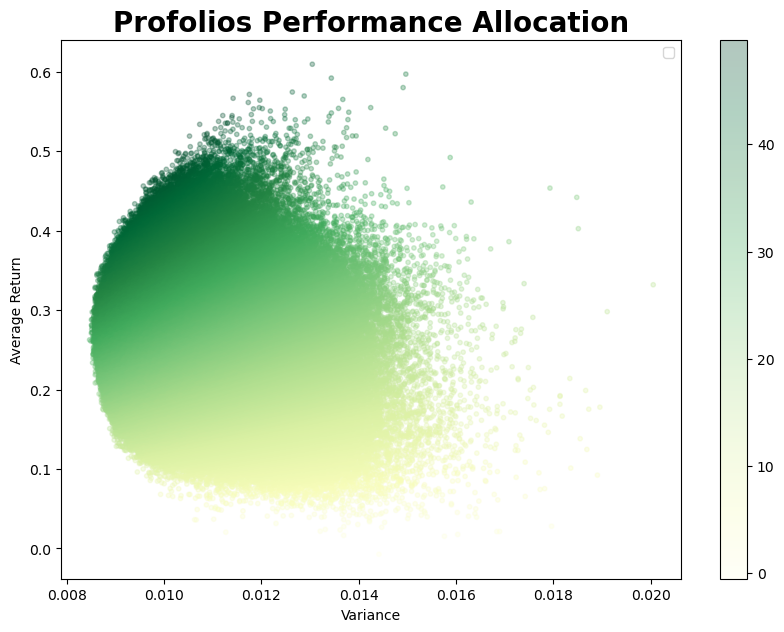

In [12]:
# 投資組合散佈圖

def profolios_allocation(mean_returns, cov_matrix, num_portfolios):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix)
      
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGn', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.title('Profolios Performance Allocation', fontsize=20,fontweight='bold',)
    plt.xlabel('Variance')
    plt.ylabel('Average Return')
    plt.legend(labelspacing=0.8)
    plt.show()
    
profolios_allocation(mean_returns, cov_matrix, num_portfolios)

In [13]:
# 建立風險函數
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[0]

# 找出投資組合中最小風險
def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0,1)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1/num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

#找到相同投資組合報酬率下最小的風險
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1/num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

#找到效率前緣樣本
def efficient_profolios(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

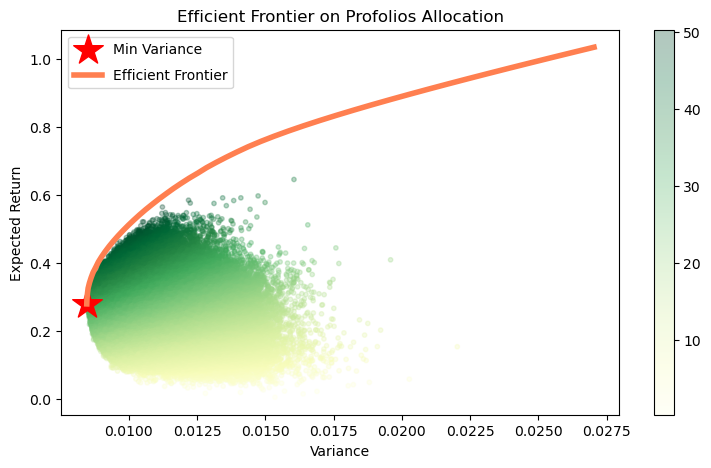

In [14]:
def display_efficient_frontier(mean_returns, cov_matrix, num_portfolios):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix)
     
    #點出所有投組報酬率及風險
    plt.figure(figsize=(9, 5))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGn', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    
    #找出最小風險投資組合及其報酬率
    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_performance(min_vol['x'], mean_returns, cov_matrix)
    
    #點出最小風險之投資組合
    plt.scatter(sdp_min,rp_min,marker='*',color='red',s=500, label='Min Variance')

    #畫出所有投組樣本的效率前緣線    
    target = np.linspace(rp_min, mean_returns.max(), 50)
    efficient_portfolios = efficient_profolios(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], 
             target, linestyle='-', color='coral',linewidth=4, label='Efficient Frontier') 
    plt.title('Efficient Frontier on Profolios Allocation')
    plt.xlabel('Variance')
    plt.ylabel('Expected Return')
    plt.legend(labelspacing=0.9 ,loc ='upper left')
    plt.show()
    
display_efficient_frontier(mean_returns, cov_matrix, num_portfolios)

以下為自己寫的不知道在幹嘛

In [12]:
from collections import Counter

#將收益率陣列長度不等於最長天數的股票刪除
def returns_length_reshape(stocks_returns):
    length = []
    for stock in stocks_returns:
        length.append(len(stocks_returns[stock]))
    max_length = Counter(length).most_common(1)[0][0]
    to_del = []
    for stock in stocks_returns:
        if len(stocks_returns[stock]) != max_length:
            #print(f'{stock} 的收益率陣列長度只有 {len(stocks_returns[stock])} 天，不等於最長天數 {max_length}')
            to_del.append(stock)

    #刪除收益率陣列長度不等於最長天數的股票
    for stock in to_del:
        del stocks_returns[stock]

#透過日報酬計算個股標準差
def standard_deviation_matrix(stocks_returns):
    returns = dict(stocks_returns)
    stocks_std = []
    for stock in returns:
        stocks_std.append(np.std(returns[stock]))
    return np.diag(stocks_std)

#計算相關係數矩陣
def correlation_matrix(stocks_returns):
    temp_dict = dict(stocks_returns)     
    size = len(temp_dict)
    correlation_matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(i+1, size):
            correlation = np.corrcoef(temp_dict[list(temp_dict.keys())[i]], temp_dict[list(temp_dict.keys())[j]])[0][1]
            correlation_matrix[i][j] = correlation
            correlation_matrix[j][i] = correlation
    np.fill_diagonal(correlation_matrix, 1)
    return correlation_matrix

#計算共變異數矩陣
def V_matrix(stocks_returns):
    V = np.dot(np.dot(standard_deviation_matrix(stocks_returns), correlation_matrix(stocks_returns)), standard_deviation_matrix(stocks_returns))
    return V

In [97]:
def get_fp(h, f):
    return h.T @ f

def variance_p(h, v):
    return h.T @ v @ h

In [98]:
def random_weight(num_stocks, num_weights):
    weight = []
    for _ in range(num_weights):
        # 生成10個隨機數字
        random_numbers = [random.random() for _ in range(num_stocks)]
        
        total = sum(random_numbers)
        
        # 將數字標準化，使總和為1
        normalized_numbers = [num / total for num in random_numbers]
        
        # 添加到結果列表中
        weight.append(normalized_numbers)
        
    return weight


In [144]:
random_50000_weights = random_weight(len(US10_Stocks), 50000)
random_10000_weights = random_weight(len(US10_Stocks), 10000)
random_2000_weights = random_weight(len(US5_Stocks), 2000)

In [139]:
def get_fp_and_pVar(random_weights, stocks_returns, f):
    fp = []
    pVar = []
    for weight in random_weights:
        h = np.array(weight).T
        v = V_matrix(stocks_returns)
        fp.append(get_fp(h, f))
        pVar.append(variance_p(h, v))
    return fp, pVar

In [145]:
US5_fp, US5_pVar = get_fp_and_pVar(random_50000_weights, US5_stocks_returns, US5_f)

In [123]:
US10_fp, US10_pVar = get_fp_and_pVar(random_10000_weights, US10_stocks_returns, US10_f)

In [103]:
def save(arr, fileName):
    with open(f'C:\\Users\\user\\Desktop\\MPTIS\\HW2\\{fileName}_dailyReturn.txt', 'w') as f:
        for item in arr:
            f.write((str(item) + '\n'))

def read(fileName):
    with open(f'C:\\Users\\user\\Desktop\\MPTIS\\HW2\\{fileName}_dailyReturn.txt', 'r') as f:
        arr = f.read().splitlines()
        arr = [float(i) for i in arr]
        return arr

In [125]:
# save(US5_fp, 'US5_fp_array')
# save(US5_pVar, 'US5_p_var_array')

US10_fp = read('US10_fp_array')
US10_pVar = read('US10_p_var_array')

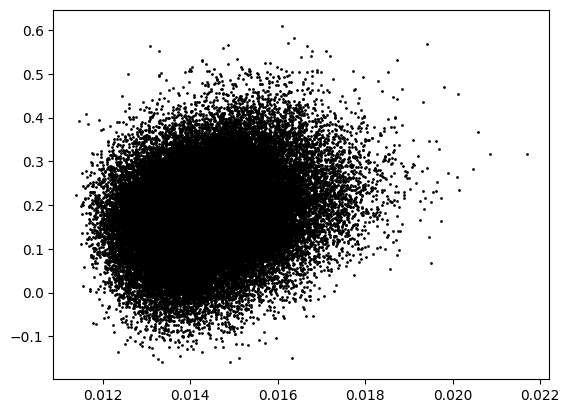

In [147]:
plt.plot(np.sqrt(US5_pVar), US5_fp, 'o', color='black', markersize=1)